In [32]:
import pandas as pd

df_data = pd.read_csv("data.csv")
print(df_data.columns.to_list())
#df_data

['age', 'BMI', 'gender', '1test Ex', '1test In', 'ComorbCCC', 'ComorbL', 'CD\\Ozhir', 'ComorbAll', 'L 109', 'LF', 'ROX', 'SpO2', 'SpO2\\FiO', 'chD', 'measurementday', 'dayshome', 'Result', '>7 or <7', 'daystoresult']


In [33]:
import torch

feature_columns = df_data.drop(
    columns=['1test Ex', '1test In',
             'ComorbCCC', 'ComorbL', 'SpO2',
             'SpO2\\FiO', 'chD', 'measurementday',
             'dayshome', 'Result',
             '>7 or <7', 'daystoresult'])
feature_tensors = torch.tensor(feature_columns.values, dtype=torch.float64)
seven_tensor = torch.tensor(df_data['>7 or <7'].values, dtype=torch.float64)

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device = torch.device("cpu")

features = feature_tensors.to(device=device)
labels7 = seven_tensor.to(device=device)

device

device(type='cpu')

In [35]:
from torch.utils.data import DataLoader
import torch.nn as nn
from NN import CustomDataset

dataset_7 = CustomDataset(
    feature_tensors=features,
    result_tensor=labels7)

batch_size = 8

dataloader7 = DataLoader(dataset_7, batch_size=batch_size, shuffle=True)

In [36]:
class NN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size) -> None:
        super(NN, self).__init__()
        self.hidd = nn.Linear(in_features=in_size, out_features=hidden_size, dtype=torch.float64)
        self.hidd_f = nn.ReLU()
        self.out = nn.Linear(in_features=hidden_size, out_features=out_size, dtype=torch.float64)
        self.out_f = nn.Sigmoid()

    def forward(self, x):
        x = self.hidd(x)
        x = self.hidd_f(x)
        x = self.out(x)
        return self.out_f(x)
    
    def get_hidden(self, x):
        with torch.no_grad():
            x = self.hidd(x)
            return self.hidd_f(x)


In [37]:
class smallNN(nn.Module):
    def __init__(self, in_size, out_size) -> None:
        super(smallNN, self).__init__()
        self.out = nn.Linear(in_features=in_size, out_features=out_size, dtype=torch.float64)
        self.out_f = nn.Sigmoid()

    def forward(self, x):
        x = self.out(x)
        return self.out_f(x)

In [38]:
in_size = features.shape[1]
hidd_size = 32
out_size = 1

lr = 0.01
num_e = 100

In [39]:
import torch.optim as optim

model = NN(in_size, hidd_size, out_size)
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr, 0.1)
criterion = nn.MSELoss()

In [55]:
for epoch in range(num_e):
    total_loss = 0.0
    for batch_x, batch_y in dataloader7:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.unsqueeze(1))  # Reshape batch_y if needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(dataloader7)
    if epoch % 10 == 0 or epoch == num_e - 1:
        print(f'Epoch [{epoch + 1}/{num_e}], Loss: {average_loss:.4f}')

Epoch [1/100], Loss: 0.1830
Epoch [11/100], Loss: 0.1856
Epoch [21/100], Loss: 0.1821
Epoch [31/100], Loss: 0.1799
Epoch [41/100], Loss: 0.1820
Epoch [51/100], Loss: 0.1831
Epoch [61/100], Loss: 0.1815
Epoch [71/100], Loss: 0.1825
Epoch [81/100], Loss: 0.1829
Epoch [91/100], Loss: 0.1821
Epoch [100/100], Loss: 0.1774


In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

predict = model(features)

y_true = labels7.to("cpu").detach().numpy()
y_scores = predict.to("cpu").detach().numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

print('AUC: ', auc)

AUC:  0.8141981196348276


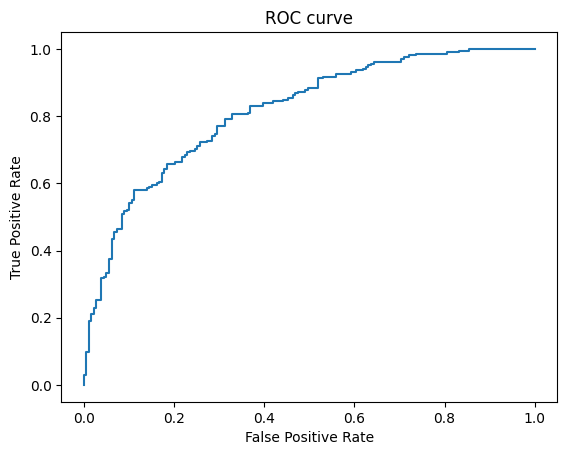

In [57]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [58]:
rows_with_0 = df_data[df_data['Result'] != 'H']

rows_with_1 = df_data[df_data['Result'] == 'H'].sample(len(rows_with_0))

small_df = pd.concat([rows_with_1, rows_with_0])

small_df.to_csv("T.csv")

In [59]:
feature_col_small = small_df.drop(
    columns=['1test Ex', '1test In',
             'ComorbCCC', 'ComorbL', 'SpO2',
             'SpO2\\FiO', 'chD', 'measurementday',
             'dayshome', 'Result',
             '>7 or <7', 'daystoresult'])

feature_tensors = torch.tensor(feature_col_small.values, dtype=torch.float64)
result_tensor = torch.tensor([1 if res == 'H' else 0 for res in small_df["Result"]], dtype=torch.float64)

In [60]:
features = feature_tensors.to(device=device)
labelsR = result_tensor.to(device=device)

In [61]:
small_model = smallNN(in_size=hidd_size, out_size=out_size)
small_model.to(device=device)
optimizer = optim.SGD(small_model.parameters(), lr, 0.1)

In [62]:
R_dataset = CustomDataset(
    feature_tensors=features,
    result_tensor=labelsR)

batch_size = 8

Rdataloader = DataLoader(R_dataset, batch_size=batch_size, shuffle=True)

In [80]:
for epoch in range(num_e):
    total_loss = 0.0
    for batch_x, batch_y in Rdataloader:
        # Forward pass
        outputs = small_model(model.get_hidden(batch_x))
        loss = criterion(outputs, batch_y.unsqueeze(1))  # Reshape batch_y if needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for this epoch
    average_loss = total_loss / len(Rdataloader)
    if epoch % 10 == 0 or epoch == num_e - 1:
        print(f'Epoch [{epoch + 1}/{num_e}], Loss: {average_loss:.4f}')

Epoch [1/100], Loss: 0.1689
Epoch [11/100], Loss: 0.1716
Epoch [21/100], Loss: 0.1712
Epoch [31/100], Loss: 0.1651
Epoch [41/100], Loss: 0.1658
Epoch [51/100], Loss: 0.1719
Epoch [61/100], Loss: 0.1701
Epoch [71/100], Loss: 0.1618
Epoch [81/100], Loss: 0.1606
Epoch [91/100], Loss: 0.1630
Epoch [100/100], Loss: 0.1603


In [81]:
predict = small_model(model.get_hidden(features))

y_true = labelsR.to("cpu").detach().numpy()
y_scores = predict.to("cpu").detach().numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

print('AUC: ', auc)

AUC:  0.8306172839506172


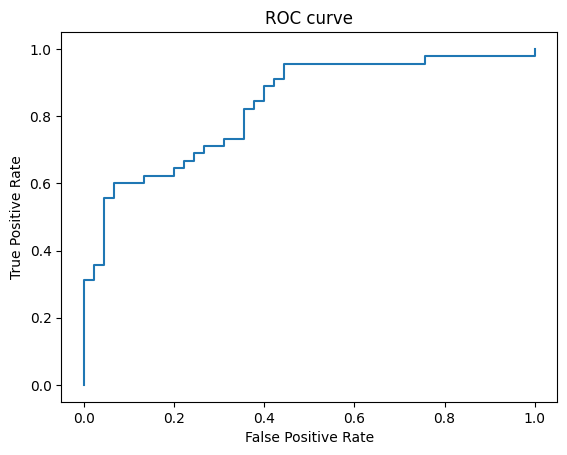

In [82]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()